<a href="https://colab.research.google.com/github/fraison/HNN/blob/master/LearningHamiltonian2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First: Make sure GPUs are enabled in this notebook from Edit->Notebook Settings.

# Here we use a Hamiltonian NN to predict the trajectory of a particle

In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

In [2]:
n_coordinates = 2
hidden = 400

# Let's set up a simulation of a 2D falling ball, launched at a random speed: 3000 launches iterated over 300 steps

In [3]:
N = 3000
p0 = np.random.rand(N, 2)
v0 = np.random.rand(N, 2)

In [4]:
p = []
v = []
T = 300

cp = p0
cv = v0
for _ in range(T):
  cp = cp + cv*0.01
  cv = cv + 0.01*(-9.81)*np.array([0, 1])[np.newaxis, :]

  p.append(cp)
  v.append(cv)

p = np.array(p).transpose(1, 0, 2)
v = np.array(v).transpose(1, 0, 2)

In [5]:
print(p.shape)


(3000, 300, 2)


# Here's a bunch of trajectories with random initial conditions:

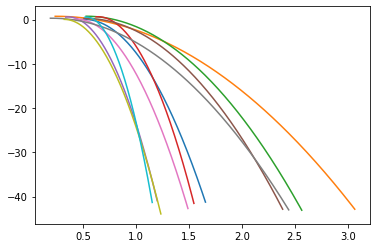

In [6]:
for i in range(10):
  plt.plot(p[i, :, 0], p[i, :, 1])

In [7]:
from torch.utils.data import DataLoader, TensorDataset

# Let's take the derivative of the neural network to use as our parameter updates:

In [8]:
tp = torch.from_numpy(p.astype(np.float32)).cuda()
tv = torch.from_numpy(v.astype(np.float32)).cuda()

#Arrange into [v0, v1, x0, x1] - X et y canonical shifted from 1 delta_t
X = torch.cat((tp[:, :-1], tv[:, :-1]), dim=2)[..., [2, 3, 0, 1]]
y = torch.cat((tp[:, 1:], tv[:, 1:]), dim=2)[..., [2, 3, 0, 1]]



M = torch.eye(n_coordinates*2).cuda()
M = torch.cat([M[n_coordinates:], -M[:n_coordinates]])
print(str(M))

# Base model (calculates H)
act = nn.Softplus
model = nn.Sequential(
    nn.Linear(n_coordinates*2, hidden), act(),
    nn.Linear(hidden, hidden), act(),
    nn.Linear(hidden, hidden), act(),
    nn.Linear(hidden, 1)
).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
print(str(model.parameters))
# Differentiates H and returns the derivatives of the canonical variables:
def canonical_model(cX):
  cX = torch.autograd.Variable(cX, requires_grad=True)
  # The final matrix multiply (@) here simply moves dH/dx to pdot, and dH/dp to xdot.
  return torch.autograd.grad(model(cX).sum(), cX, create_graph=True)[0] @ M.t()

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-1., -0., -0., -0.],
        [-0., -1., -0., -0.]], device='cuda:0')
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=4, out_features=400, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=400, out_features=1, bias=True)
)>


Here a sample of the training set

In [11]:
mX = torch.cat((tp[0:2, :299,:], tv[0:2, :299,:]), dim=2)[..., [2, 3, 0, 1]]
my = torch.cat((tp[0:2, 1:300,:], tv[0:2, 1:300,:]), dim=2)[..., [2, 3, 0, 1]]
mX.shape

torch.Size([2, 299, 4])

# Here we set up our dataset to train on :

In [12]:
trainset = TensorDataset(X[:N*3//4*300].reshape(-1, 4), y[:N*3//4*300].reshape(-1, 4))
testset = TensorDataset(X[N*3//4*300:].reshape(-1, 4), y[N*3//4*300:].reshape(-1, 4))
train = DataLoader(trainset, shuffle=True, batch_size=512)
test = DataLoader(testset, shuffle=False, batch_size=512)

In [13]:
loss_fn = nn.MSELoss()
print(N*3//4*300)
print(X.shape)
print(testset.__sizeof__())



675000
torch.Size([3000, 299, 4])
32


Training

In [14]:
for _ in range(10):
  all_loss = 0.0
  for (cX, cy) in train:
    test_y = canonical_model(cX)
    loss = loss_fn(test_y, cy-cX)
    loss.backward()
    opt.step()
    opt.zero_grad()
    all_loss += loss.item()*512

  print(all_loss/len(trainset))

3.271338839530753e-05
3.06960562994333e-07
2.5472934012031446e-07
2.434910508935299e-07
2.1678224431825574e-07
1.9127278610661759e-07
1.666036231722222e-07
1.5570642424987706e-07
1.4069946560525705e-07
1.3366509453185413e-07


Here we can look at the prediction:

In [15]:
for (cX, cy) in test:
  test_y = canonical_model(cX)
  print(cy.shape)
  break


In [16]:
test_y, cy - cX

(tensor([[-8.0993e-05, -9.8125e-02,  9.5451e-03, -7.1371e-02],
         [-5.5589e-05, -9.8410e-02,  4.8404e-03, -2.0247e-01],
         [-7.6261e-05, -9.8353e-02,  8.6494e-03, -2.0503e-01],
         ...,
         [-1.3520e-04, -9.8155e-02,  7.5656e-03, -4.7367e-02],
         [-6.6329e-05, -9.8121e-02,  2.2560e-03, -7.7297e-03],
         [-1.1537e-04, -9.8111e-02,  4.9825e-03, -1.3209e-02]], device='cuda:0',
        grad_fn=<MmBackward>), tensor([[ 0.0000, -0.0981,  0.0093, -0.0713],
         [ 0.0000, -0.0981,  0.0047, -0.2023],
         [ 0.0000, -0.0981,  0.0085, -0.2050],
         ...,
         [ 0.0000, -0.0981,  0.0074, -0.0473],
         [ 0.0000, -0.0981,  0.0021, -0.0077],
         [ 0.0000, -0.0981,  0.0048, -0.0132]], device='cuda:0'))

# As we can see, the Hamiltonian NN has very closely learned the dynamics with very little training

# Homework problems:
0. Plot the resultant trajectories of a HNN.
1. Plot H over the relevant parameter space. Create a vector field showing its predicted path.
2. Write an RK4 method for this neural network.

run HNN on sample

In [17]:

mmX = mX.cpu()
print(mmX.shape)
mmy = my.cpu()
#run forward
mtest_y = canonical_model(mX)
mmtest_y = mtest_y.cpu()
print(mmtest_y.shape)

(mmX[0,:, 3]+mmtest_y[0,:, 3]).shape

torch.Size([2, 299, 4])
torch.Size([2, 299, 4])


torch.Size([299])

torch.Size([488, 4])
torch.Size([488, 4])
torch.Size([2, 299, 4])
torch.Size([299])
torch.Size([299])
torch.Size([2, 299, 4])


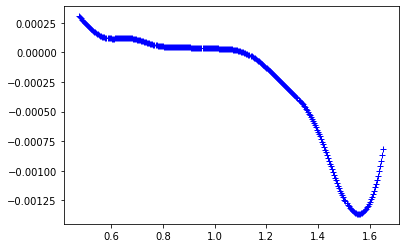

In [18]:
print(cy.shape)
print(test_y.shape)
print(mtest_y.shape)

# Prediction error on y vs x
a= mmX[0,:, 2]
b =mmtest_y[0,:, 3]-(mmy[0,:, 3]-mmX[0,:, 3])
print(a.shape)
print(b.shape)
print(mmy.shape)
plt.plot(a,b.detach().numpy(),"b+")
#print(b.detach().numpy())
#print(mmy[0,:, 3].detach().numpy())


tensor([0.3951, 0.7176, 0.4791, 0.0189], device='cuda:0')
tensor([ 3.3013e-05, -9.7888e-02,  3.8201e-03,  8.4622e-03], device='cuda:0',
       grad_fn=<SqueezeBackward3>)
torch.Size([299, 4])
[[ 3.9506927e-01  8.1569445e-01  4.7518113e-01  1.0693666e-02]
 [ 3.9510229e-01  7.1780658e-01  4.7900128e-01  1.9155877e-02]
 [ 3.9513758e-01  6.1988759e-01  4.8281839e-01  2.6629845e-02]
 ...
 [ 4.3025729e-01 -2.8214233e+01  1.6496923e+00 -4.0449677e+01]
 [ 4.3041202e-01 -2.8312853e+01  1.6539174e+00 -4.0732857e+01]
 [ 4.3056685e-01 -2.8411512e+01  1.6581547e+00 -4.1016972e+01]]


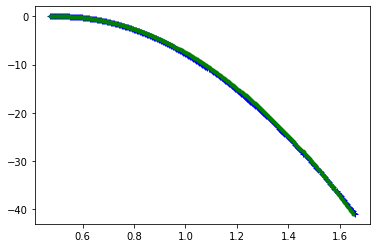

In [50]:
#QUESTION 0: 2 trajectories from training sample 
# need to iterate from an initial value and compare to train
dp1_ref = mmX[0,:, 2]
dp2_ref = mmX[0,:, 3]

imtest_y = canonical_model(mX[0,0,:])
print(my[0,0,:])
print(imtest_y)

#trajFromHNN=  torch.tensor(mX[0,:,:])
trajFromHNN=  mX[0,:,:].clone()#.detach()
#trajFromHNN.new_zeros(mX[0,:,:])

trajFromHNN[0,:] = mX[0,0,:]
print(trajFromHNN.shape)

for i in range(0,298):
  trajFromHNN[i+1,:]=canonical_model(trajFromHNN[i,:])+trajFromHNN[i,:]

ctrajFromHNN=trajFromHNN.cpu().detach().numpy()
plt.plot(ctrajFromHNN[:, 2], ctrajFromHNN[:, 3],"b+",mmX[0,:, 2],mmX[0,:, 3],"g.")
print(ctrajFromHNN)

torch.Size([488, 4])
tensor([[ 8.9345e-01, -7.2153e+00,  1.1662e+00, -2.5676e+00],
        [ 9.8232e-01, -4.3587e+00,  1.4321e+00, -2.5308e-02],
        [ 1.7329e-01, -1.3528e+01,  3.6728e-01, -8.6198e+00],
        [ 4.1592e-01, -1.2030e+01,  9.0874e-01, -6.4632e+00],
        [ 8.0374e-01, -2.7444e+01,  3.0222e+00, -3.7731e+01],
        [ 6.2176e-01, -1.6745e+01,  1.3880e+00, -1.3513e+01],
        [ 3.5348e-01, -9.0294e+00,  8.5518e-01, -3.4640e+00],
        [ 5.6384e-01, -2.5487e+01,  2.2254e+00, -3.2347e+01],
        [ 3.9172e-01, -2.4730e+01,  1.3574e+00, -3.0448e+01],
        [ 4.9197e-01, -4.2067e+00,  4.5143e-01,  7.5146e-02]])
tensor([], size=(2, 0), dtype=torch.int64)


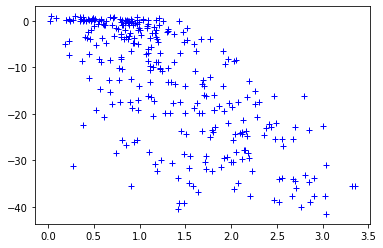

In [30]:
#Note that the DataLoader is mixing everything

#mycx+ test_y and mycy 
mycy=cy.cpu()
mycx = cX.cpu()

print(mycx.shape)
print(mycx[:10,:])

plt.plot(mycx[:300, 2], mycx[:300, 3],"b+")